<a href="https://colab.research.google.com/github/dancimiluca/DATA602/blob/master/Copy_of_CIMILUCA_11_AlexImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [0]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from matplotlib import pyplot
from matplotlib import pylab
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score

Setup the GPU

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Setup the dataset, plot some of the faces

/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

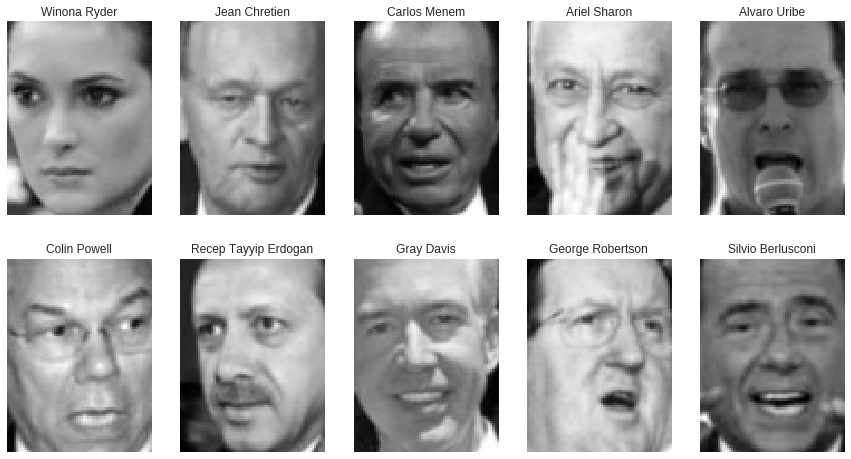

In [0]:
people = datasets.fetch_lfw_people(min_faces_per_person=20, resize=.7 )
image_shape = people.images[0].shape
fig, axes = pyplot.subplots(2, 5, figsize=(15,8),
                    subplot_kw={'xticks': (), 'yticks':()})
for target, image, ax in zip(people.target,people.images, axes.ravel()):
  ax.imshow(image, cmap=pyplot.cm.gray)
  ax.set_title(people.target_names[target])


Remove "heavy hitter" faces, create train, test and validation sets.

In [0]:
# now less get rid of the "heavy hitters"
mask = np.zeros( people.target.shape, dtype=np.bool )
for i in np.unique(people.target): mask[np.where(people.target==i)[0][:50]]=True
people_X = people.data[mask]
people_Y = people.target[mask]
train_X, test_X = train_test_split(people_X/255, test_size =.4, random_state=1)
train_Y, test_Y = train_test_split(people_Y, test_size =.4, random_state=1)
test_X, val_X = train_test_split(test_X, test_size = .5, random_state=1)
test_Y, val_Y = train_test_split(test_Y, test_size = .5, random_state=1)


Utility Functions

In [0]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
# Gets the flattened dimension of a tensor so reshape is easier
def get_flattened_dim(tensor):
  prod = 1
  for i in map(lambda x: x.value, tensor.get_shape()[1:4]): prod = prod*i
  print(prod)
  return prod

Setup inputs

In [0]:
n_inputs = 87 * 65
n_outputs = len(people.target_names)
reset_graph()
X = tf.placeholder( tf.float32, shape=(None,n_inputs), name = 'X')
X_reshaped = tf.reshape(X,shape=[-1,87,65,1])
y = tf.placeholder( tf.int64, shape=None, name = 'y')

Setup the NN archeture

In [0]:
cnn1 = tf.layers.conv2d( X_reshaped , filters=64, kernel_size=11, strides=4 , padding='VALID', activation= tf.nn.relu, name='cnn1')
pool2 = tf.layers.max_pooling2d(cnn1, pool_size=3, strides=(2,2), padding='VALID', name='pool2')
cnn3 = tf.layers.conv2d( pool2 , filters=128, kernel_size=5 , strides=1, padding='SAME', activation= tf.nn.relu, name='cnn3')
pool4 = tf.layers.max_pooling2d(cnn3, pool_size=3, strides=(2,2), padding='VALID', name='pool4')
cnn5 = tf.layers.conv2d( pool4 , filters=64, kernel_size=3 , strides=1, padding='SAME', activation= tf.nn.relu, name='cnn5')
cnn6 = tf.layers.conv2d( cnn5 , filters=64, kernel_size=3 , strides=1, padding='SAME', activation= tf.nn.relu, name='cnn6')
cnn7 = tf.layers.conv2d( cnn6 , filters=32, kernel_size=3 , strides=1, padding='SAME', activation= tf.nn.relu, name='cnn7')
pool_flat = tf.reshape(cnn7, shape=[-1, get_flattened_dim(cnn7)], name='pool_flat')
#pool_flat = tf.reshape(pool4, shape=[-1, get_flattened_dim(pool4)], name='pool_flat')
hidden1 = tf.layers.dense(pool_flat, 1024, activation=tf.nn.relu, name='hidden1')
hidden2 = tf.layers.dense(hidden1, 100, activation=tf.nn.relu, name='hidden2')
logits = tf.layers.dense(hidden2, n_outputs, name = 'outputs' )

256


Setup Loss function

In [0]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy, name = 'loss')
optimizer = tf.train.GradientDescentOptimizer(.01)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits,y,1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Train the net!

In [0]:
batch_size = 50
n_epochs = 1000
min_queue_examples = 10
with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for i in range(len(train_Y) // batch_size):
      X_batch= train_X[i*batch_size:(i+1)*batch_size -1]
      y_batch= train_Y[i*batch_size:(i+1)*batch_size -1]
      sess.run( training_op, feed_dict = {X: X_batch, y: y_batch})
    if(epoch%50==0): 
      print('epoch: {1}'.format(i,epoch))
      print(accuracy.eval(feed_dict = {X: test_X, y: test_Y}))
  saver.save(sess, './faces.model')

epoch: 0
0.016949153
epoch: 50
0.021791767
epoch: 100
0.02905569
epoch: 150
0.02905569
epoch: 200
0.04842615
epoch: 250
0.092009686
epoch: 300
0.20338982
epoch: 350
0.27118644
epoch: 400
0.3874092
epoch: 450
0.3946731
epoch: 500
0.40193704
epoch: 550
0.39225182
epoch: 600
0.3946731
epoch: 650
0.3946731
epoch: 700
0.3946731
epoch: 750
0.39225182
epoch: 800
0.39225182
epoch: 850
0.39225182
epoch: 900
0.39225182
epoch: 950
0.39225182


Try our validation set

In [0]:
with tf.Session() as sess:
  init.run()
  saver.restore(sess, './faces.model')
  pred = sess.run(accuracy,feed_dict= {X: val_X, y: val_Y})
  print(pred)

INFO:tensorflow:Restoring parameters from ./faces.model
0.3898305


Let's at least test of the people we left out.  These were the heavy hitters so we've got at least 50 images of these in our training set.  This is a bit easier than a validation set.

In [0]:
mask = np.zeros( people.target.shape, dtype=np.bool )
for i in np.unique(people.target): mask[np.where(people.target==i)[0][50:]]=True
common_people_X = people.data[mask]
common_people_Y = people.target[mask]
with tf.Session() as sess:
  init.run()
  saver.restore(sess, './faces.model')
  pred = sess.run(accuracy,feed_dict= {X: common_people_X, y: common_people_Y})
  print(pred)


INFO:tensorflow:Restoring parameters from ./faces.model
0.415625


Better than random?

How could we do better?
- More data! But how?
- Augment the data by shifting the images to the left, right, up or down by 1-5 pixels
- rotate the pictures by 1-5 degrees
- do both


Example of rotation

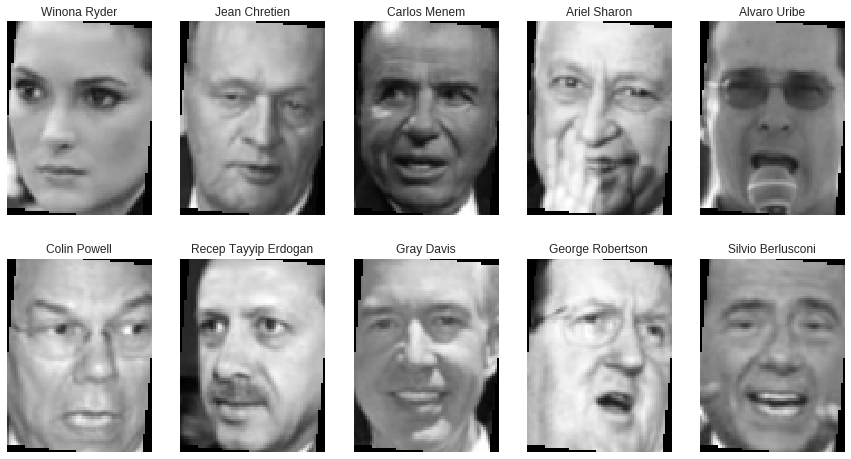

In [0]:
from scipy import ndimage
people = datasets.fetch_lfw_people(min_faces_per_person=20, resize=.7 )
image_shape = people.images[0].shape
fig, axes = pyplot.subplots(2, 5, figsize=(15,8),
                    subplot_kw={'xticks': (), 'yticks':()})
for target, image, ax in zip(people.target,people.images, axes.ravel()):
  image = ndimage.rotate(image, -5, reshape=False )
  ax.imshow(image, cmap=pyplot.cm.gray)
  ax.set_title(people.target_names[target])

Example of shift

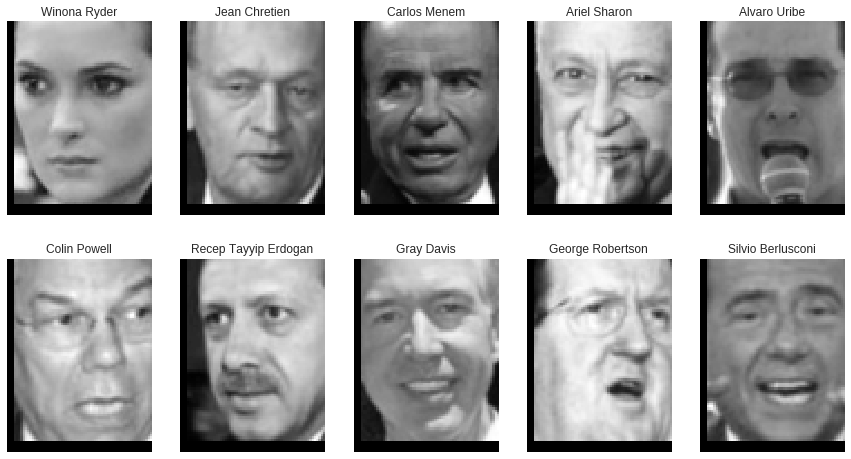

In [0]:
people = datasets.fetch_lfw_people(min_faces_per_person=20, resize=.7 )
image_shape = people.images[0].shape
fig, axes = pyplot.subplots(2, 5, figsize=(15,8),
                    subplot_kw={'xticks': (), 'yticks':()})
for target, image, ax in zip(people.target,people.images, axes.ravel()):
  image = ndimage.shift(image, (-5,3))
  ax.imshow(image, cmap=pyplot.cm.gray)
  ax.set_title(people.target_names[target])

In [0]:
data = np.concatenate((people.images,
                      [ndimage.shift(image, (1,0)) for image in people.images],
                      [ndimage.shift(image, (2,0)) for image in people.images],
                      [ndimage.shift(image, (3,0)) for image in people.images],
                      [ndimage.shift(image, (4,0)) for image in people.images],
                      [ndimage.shift(image, (5,0)) for image in people.images],
                      [ndimage.shift(image, (-1,0)) for image in people.images],
                      [ndimage.shift(image, (-2,0)) for image in people.images],
                      [ndimage.shift(image, (-3,0)) for image in people.images],
                      [ndimage.shift(image, (-4,0)) for image in people.images],
                      [ndimage.shift(image, (-5,0)) for image in people.images],
                      [ndimage.shift(image, (0,1)) for image in people.images],
                      [ndimage.shift(image, (0,2)) for image in people.images],
                      [ndimage.shift(image, (0,3)) for image in people.images],
                      [ndimage.shift(image, (0,4)) for image in people.images],
                      [ndimage.shift(image, (0,5)) for image in people.images],
                      [ndimage.shift(image, (0,-1)) for image in people.images],
                      [ndimage.shift(image, (0,-2)) for image in people.images],
                      [ndimage.shift(image, (0,-3)) for image in people.images],
                      [ndimage.shift(image, (0,-4)) for image in people.images],
                      [ndimage.shift(image, (0,-5)) for image in people.images],
                      [ndimage.rotate(image, 1, reshape=False) for image in people.images],
                      [ndimage.rotate(image, 2, reshape=False) for image in people.images],
                      [ndimage.rotate(image, 3, reshape=False) for image in people.images],
                      [ndimage.rotate(image, 4, reshape=False) for image in people.images],
                      [ndimage.rotate(image, 5, reshape=False) for image in people.images],
                      [ndimage.rotate(image, 6, reshape=False) for image in people.images],
                      [ndimage.rotate(image, 7, reshape=False) for image in people.images],
                      [ndimage.rotate(image, 8, reshape=False) for image in people.images],
                      [ndimage.rotate(image, 9, reshape=False) for image in people.images],
                      [ndimage.rotate(image, 10, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -1, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -2, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -3, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -4, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -5, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -6, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -7, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -8, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -9, reshape=False) for image in people.images],
                      [ndimage.rotate(image, -10, reshape=False) for image in people.images],

                      ),
                      axis = 0
                     ).reshape(-1,87*65)
target=np.tile(people.target, 41)

In [0]:
# now less get rid of the "heavy hitters"
mask = np.zeros( target.shape, dtype=np.bool )
for i in np.unique(target): mask[np.where(people.target==i)[0][:1550]]=True
people_X = data[mask]
people_Y = target[mask]
train_X, test_X = train_test_split(people_X/255, random_state=1)
train_Y, test_Y = train_test_split(people_Y, random_state=1)
test_X, val_X = train_test_split(test_X, test_size =.5, random_state=1)
test_Y, val_Y = train_test_split(test_Y, test_size =.5, random_state=1)


Go run training and validation above, how did it go?

In [0]:
41*50

2050

In [0]:
#Trying out validation set
with tf.Session() as sess:
  init.run()
  saver.restore(sess, './faces.model')
  pred = sess.run(accuracy,feed_dict= {X: val_X, y: val_Y})
  print(pred)

INFO:tensorflow:Restoring parameters from ./faces.model
0.6666667


In [0]:
#Now running training set
with tf.Session() as sess:
  init.run()
  saver.restore(sess, './faces.model')
  pred = sess.run(accuracy,feed_dict= {X: test_X, y: test_Y})
  print(pred)

INFO:tensorflow:Restoring parameters from ./faces.model
0.65873015


This appears to have performed better than the original, for both training and validation sets. There was around 25% better performance in both cases after manipulating the data.